In [46]:


import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.subplots as sp
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score




In [47]:
! wget "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+non+Supervis%C3%A9/Projects/uber-trip-data.zip"

--2023-11-16 06:18:43--  https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+non+Supervis%C3%A9/Projects/uber-trip-data.zip
Resolving full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com (full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com)... 16.12.18.30, 52.95.154.76
Connecting to full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com (full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com)|16.12.18.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101042186 (96M) [application/zip]
Saving to: ‘uber-trip-data.zip.1’

uber-trip-data.zip. 100%[===================>]  96.36M  25.3MB/s    in 3.8s    

2023-11-16 06:18:47 (25.3 MB/s) - ‘uber-trip-data.zip.1’ saved [101042186/101042186]



In [48]:
!unzip uber-trip-data.zip

Archive:  uber-trip-data.zip
replace __MACOSX/._uber-trip-data? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [49]:


avril = pd.read_csv('/content/uber-trip-data/uber-raw-data-apr14.csv')
# aout = pd.read_csv('./data/uber-trip-data/uber-trip-data/uber-raw-data-aug14.csv')
# janjuin = pd.read_csv('./data/uber-trip-data/uber-trip-data/uber-raw-data-janjune-15.csv')
# juil = pd.read_csv('./data/uber-trip-data/uber-trip-data/uber-raw-data-jul14.csv')
# jun = pd.read_csv('./data/uber-trip-data/uber-trip-data/uber-raw-data-jun14.csv')
# may = pd.read_csv('./data/uber-trip-data/uber-trip-data/uber-raw-data-may14.csv')
# sep = pd.read_csv('./data/uber-trip-data/uber-trip-data/uber-raw-data-sep14.csv')



# EDA sur un dataset

Nous commençons une analyse exploratoire des données pour le mois d'avril pour commencer petit puis viser plus large

In [50]:
avril.head()
# for column in avril.columns:
#     print(column)

Date/Time      Lat      Lon    Base
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512

In [51]:
# Convert time into day of the week and hour
avril['Date'] =  pd.to_datetime(avril['Date/Time'])
avril['Day_of_week'] = avril.Date.dt.day_name()
avril['Hour'] = avril.Date.dt.hour
# Remove original datetime and useless column Base
avril = avril.drop(columns=['Date/Time','Base'])
# Create column for visualization
avril['Type'] = avril['Day_of_week'].apply(lambda x: 'Friday' if x == 'Friday' else 'Saturday' if x == 'Saturday' else 'Sunday' if x == 'Sunday' else 'Weekday')
print(avril)


            Lat      Lon                Date Day_of_week  Hour     Type
0       40.7690 -73.9549 2014-04-01 00:11:00     Tuesday     0  Weekday
1       40.7267 -74.0345 2014-04-01 00:17:00     Tuesday     0  Weekday
2       40.7316 -73.9873 2014-04-01 00:21:00     Tuesday     0  Weekday
3       40.7588 -73.9776 2014-04-01 00:28:00     Tuesday     0  Weekday
4       40.7594 -73.9722 2014-04-01 00:33:00     Tuesday     0  Weekday
...         ...      ...                 ...         ...   ...      ...
564511  40.7640 -73.9744 2014-04-30 23:22:00   Wednesday    23  Weekday
564512  40.7629 -73.9672 2014-04-30 23:26:00   Wednesday    23  Weekday
564513  40.7443 -73.9889 2014-04-30 23:31:00   Wednesday    23  Weekday
564514  40.6756 -73.9405 2014-04-30 23:32:00   Wednesday    23  Weekday
564515  40.6880 -73.9608 2014-04-30 23:48:00   Wednesday    23  Weekday

[564516 rows x 6 columns]


In [52]:
unique_types = avril['Type'].unique()
print(unique_types)

['Weekday' 'Friday' 'Saturday' 'Sunday']


In [53]:
avril.describe(include='all')

<ipython-input-53-27cb054beab0>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



Lat            Lon                 Date Day_of_week  \
count   564516.000000  564516.000000               564516      564516   
unique            NaN            NaN                41999           7   
top               NaN            NaN  2014-04-07 20:21:00   Wednesday   
freq              NaN            NaN                   97      108631   
first             NaN            NaN  2014-04-01 00:00:00         NaN   
last              NaN            NaN  2014-04-30 23:59:00         NaN   
mean        40.740005     -73.976817                  NaN         NaN   
std          0.036083       0.050426                  NaN         NaN   
min         40.072900     -74.773300                  NaN         NaN   
25%         40.722500     -73.997700                  NaN         NaN   
50%         40.742500     -73.984800                  NaN         NaN   
75%         40.760700     -73.970000                  NaN         NaN   
max         42.116600     -72.066600                  NaN         NaN   

                 Hour     Type  
count   564516.000000   564516  
unique            NaN        4  
top               NaN  Weekday  
freq              NaN   345744  
first             NaN      NaN  
last              NaN      NaN  
mean        14.465043      NaN  
std          5.873925      NaN  
min          0.000000      NaN  
25%         10.000000      NaN  
50%         16.000000      NaN  
75%         19.000000      NaN  
max         23.000000      NaN

In [54]:
display(100*avril.isnull().sum()/avril.shape[0])

Lat            0.0
Lon            0.0
Date           0.0
Day_of_week    0.0
Hour           0.0
Type           0.0
dtype: float64

Le dataframe ne comporte pas de valeurs manquantes

In [55]:


# Uber demands distribution along the week
histogram = go.Histogram(x=avril['Day_of_week'])
layout = go.Layout(title='Distribution of Uber Demands over the Week')
fig = go.Figure(data=[histogram], layout=layout)
fig.show()



Nous pouvons d'ores et déjà observer que le nombre de demandes est le plus élevé le mercredi .

In [56]:
# Créez des catégories pour les plages horaires
bins = [-1, 5, 11, 14, 16, 20, 24]  # Étendre la plage à 24 pour inclure toutes les heures
labels = ['Early_morning', 'Morning', 'Lunch', 'Work', 'Afterwork', 'Early_night']

# Utilisez pd.cut sans l'argument right=False
avril['Hour_bin'] = pd.cut(avril['Hour'], bins=bins, labels=labels)

print(avril)

            Lat      Lon                Date Day_of_week  Hour     Type  \
0       40.7690 -73.9549 2014-04-01 00:11:00     Tuesday     0  Weekday   
1       40.7267 -74.0345 2014-04-01 00:17:00     Tuesday     0  Weekday   
2       40.7316 -73.9873 2014-04-01 00:21:00     Tuesday     0  Weekday   
3       40.7588 -73.9776 2014-04-01 00:28:00     Tuesday     0  Weekday   
4       40.7594 -73.9722 2014-04-01 00:33:00     Tuesday     0  Weekday   
...         ...      ...                 ...         ...   ...      ...   
564511  40.7640 -73.9744 2014-04-30 23:22:00   Wednesday    23  Weekday   
564512  40.7629 -73.9672 2014-04-30 23:26:00   Wednesday    23  Weekday   
564513  40.7443 -73.9889 2014-04-30 23:31:00   Wednesday    23  Weekday   
564514  40.6756 -73.9405 2014-04-30 23:32:00   Wednesday    23  Weekday   
564515  40.6880 -73.9608 2014-04-30 23:48:00   Wednesday    23  Weekday   

             Hour_bin  
0       Early_morning  
1       Early_morning  
2       Early_morning  
3  

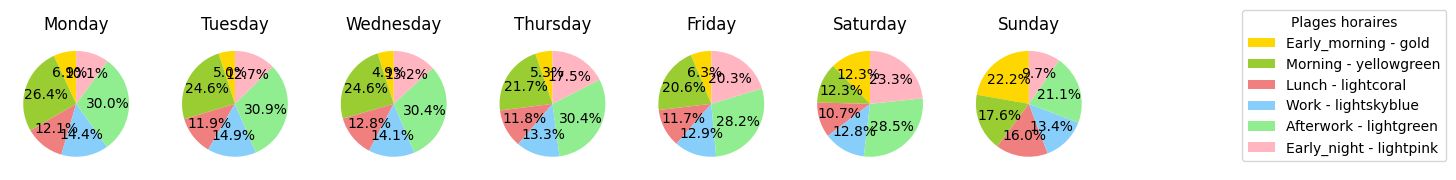

In [57]:


# Grouper le DataFrame par 'Day_of_week' et 'Hour_bin', puis compter les occurrences
grouped = avril.groupby(['Day_of_week', 'Hour_bin']).size().unstack()

# Liste des couleurs à utiliser
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'lightpink']

# Créer des sous-plots pour chaque jour de la semaine
fig, axs = plt.subplots(1, 7, figsize=(14, 2), subplot_kw={'aspect': 'equal'})
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, day in enumerate(days):
    # Récupérer les données pour le jour en cours
    data = grouped.loc[day].dropna()
    sizes = data.values

    wedges, texts, autotexts = axs[i].pie(sizes, labels=None, colors=colors, autopct='%1.1f%%', startangle=90)
    axs[i].set_title(day)

# Créer une légende séparée pour les labels en dehors de l'espace des camemberts
legend_labels = [f"{label} - {color}" for label, color in zip(data.index, colors)]
legend = fig.legend(wedges, legend_labels, title="Plages horaires", loc='upper left', bbox_to_anchor=(1, 1))

plt.show()



Les demandes UBER sont sensiblement les même entre jours de la semaine excepté pour les weekend où il y a plus de demande au petit matin (early morning) par rapport aux jours de la semaine.

In [58]:
# General map of uber demands in April

# fig = px.scatter_mapbox(title="Uber demands in NYC", data_frame=avril,lat='Lat',lon='Lon',color='Hour',mapbox_style='open-street-map')
# fig.show(renderer='notebook')


Nous constatons d'ores et déjà une demande très importante au centre de New York

# KMEANS

## Visualisation en semaine

On constitue deux échantillons , un pour les heures de pointe en semaine un vendredi en fin d'après midi après le travail  et un autre pour les heures creuses le dimanche en soirée à 21h

In [59]:
to_keep = (avril['Day_of_week']=='Friday') & (avril['Hour']==18)
data_test_1 = avril.loc[to_keep,:]
to_keep = (avril['Day_of_week']=='Sunday') & (avril['Hour']==21)
data_test_2 = avril.loc[to_keep,:]

In [60]:
scaler = StandardScaler()
X1 = scaler.fit_transform(data_test_1[['Lat','Lon']])
X2 = scaler.fit_transform(data_test_2[['Lat','Lon']])

In [61]:
kmeans = KMeans(n_clusters = 100)

In [62]:
kmeans.fit(X1)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=100)

In [63]:
data_test_1['cluster'] = kmeans.labels_

Nous devons déterminer combien de points appartiennent à chaque cluster, ce qui nous permettra de trier et de décider lesquels afficher. La méthode value_counts() est utile à cet égard, car elle nous aide à organiser les clusters en fonction du nombre d'observations qu'ils contiennent. Si un cluster contient un nombre insuffisant de points, et donc de statistiques, nous évitons de l'afficher. En réalité, c'est notre manière de résoudre le problème propre à KMEANS, qui, contrairement à DBSCAN, génère un grand nombre de clusters sans tenir compte de la densité. Nous créons de nombreux clusters, mais nous choisissons de ne montrer que les petits clusters suffisamment denses tout en excluant ceux qui sont peu peuplés en observations.


In [64]:
data_test_1['cluster'].value_counts()

46    394
0     366
14    260
79    258
75    252
     ... 
10      1
80      1
56      1
34      1
70      1
Name: cluster, Length: 100, dtype: int64

On crée une liste appelée cluster_counts qui contient le nombre de points de données dans chaque cluster, en se basant sur le DataFrame data_test_1. Cette liste pourra être utilisée pour effectuer des analyses ou des visualisations basées sur la distribution des données dans les clusters.

In [65]:
cluster_counts = data_test_1.groupby('cluster').count()['Date'].tolist()

Nous pouvons introduire une nouvelle colonne, 'disp', dans notre DataFrame, qui contiendra des valeurs binaires ("True" ou "False") pour gérer l'affichage des clusters. Cette colonne déterminera si un cluster doit être visible ou non.

La condition pour qu'un cluster soit affiché est qu'il contienne au moins 50 points de données en termes de taille (c'est-à-dire, 50 demandes ou observations). Cette valeur est essentiellement un choix arbitraire, basé sur l'idée de disposer d'au moins 10 données minimales pour chaque tranche d'une heure de la semaine sur une période de 5 semaines. Par conséquent, lorsque nous affichons un cluster, cela signifie que nous pouvons informer les utilisateurs qu'il y a en moyenne 10 demandes dans cette zone pour une heure spécifique de la semaine.

In [66]:
data_test_1['disp'] = data_test_1['cluster'].map(lambda c : cluster_counts[c]>50)

In [67]:
fig = px.scatter_mapbox(data_test_1.loc[data_test_1['disp']==True,:], lat='Lat', lon='Lon', color='cluster', mapbox_style='carto-positron')
fig.show()

## Visualisation le weekend

Nous répétons exactement le même processus que ci-dessus

In [68]:
kmeans.fit(X2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=100)

In [69]:
data_test_2['cluster'] = kmeans.labels_

In [70]:
cluster_counts_2 = data_test_2.groupby('cluster').count()['Date'].to_numpy()
data_test_2['disp'] = data_test_2['cluster'].map(lambda c : cluster_counts_2[c]>50)
data_test_2

Lat      Lon                Date Day_of_week  Hour    Type  \
7730    40.7543 -74.0251 2014-04-06 21:00:00      Sunday    21  Sunday   
7731    40.7543 -74.0251 2014-04-06 21:00:00      Sunday    21  Sunday   
7732    40.6878 -74.1826 2014-04-06 21:00:00      Sunday    21  Sunday   
7733    40.7628 -73.9894 2014-04-06 21:03:00      Sunday    21  Sunday   
7734    40.7321 -74.0037 2014-04-06 21:04:00      Sunday    21  Sunday   
...         ...      ...                 ...         ...   ...     ...   
563258  40.7306 -74.0000 2014-04-27 21:44:00      Sunday    21  Sunday   
563259  40.7230 -73.9988 2014-04-27 21:45:00      Sunday    21  Sunday   
563260  40.7113 -73.9469 2014-04-27 21:46:00      Sunday    21  Sunday   
563261  40.6450 -73.7819 2014-04-27 21:52:00      Sunday    21  Sunday   
563262  40.6454 -73.7823 2014-04-27 21:56:00      Sunday    21  Sunday   

           Hour_bin  cluster   disp  
7730    Early_night       45  False  
7731    Early_night       45  False  
7732    Early_night        6  False  
7733    Early_night       89  False  
7734    Early_night       95   True  
...             ...      ...    ...  
563258  Early_night       33   True  
563259  Early_night       49   True  
563260  Early_night       99  False  
563261  Early_night       38   True  
563262  Early_night       38   True  

[2310 rows x 9 columns]

In [71]:
fig = px.scatter_mapbox(data_test_2.loc[data_test_2['disp']==True,:], lat='Lat', lon='Lon', color='cluster', mapbox_style='carto-positron')
fig.show()

## Visualisation  sur la semaine entière

In [72]:
data_join = pd.concat([data_test_1,data_test_2], axis=0)

 On crée une carte interactive basée sur les données de data_join, où seuls les clusters marqués pour affichage sont représentés, avec des marqueurs colorés en fonction des clusters, et une option d'animation pour visualiser les changements au fil du temps.

In [73]:


fig = px.scatter_mapbox(data_join.loc[data_join['disp']==True,:], lat='Lat', lon='Lon', color='cluster',animation_frame='Hour', mapbox_style='carto-positron')
fig.show()



## Visualisation centroides

Dans cette deuxième méthode d'affichage, qui se concentre sur les centres des clusters, nous obtenons les coordonnées de ces centres en utilisant l'attribut 'cluster_centers_'.

In [74]:
kmeans.cluster_centers_[0:5]

array([[ 0.43163885, -0.43898785],
       [-1.97780264,  2.38248903],
       [-0.86360807, -0.45319835],
       [ 0.9205835 ,  1.31337868],
       [ 2.74516144,  0.31863786]])

Les données sont normalisées et nous souhaitons des coordonnées GPS. Donc on transforme les coordonnées des centres de cluster (calculés par l'algorithme k-means) pour les ramener à leur échelle d'origine, puis on les stocke dans un nouveau DataFrame Pandas appelé df_clusters avec des colonnes distinctes pour les latitudes et les longitudes. Cela peut être utile pour une analyse ultérieure et pour créer des visualisations basées sur ces centres de cluster.

In [75]:
df_clusters = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),columns=['Lat','Lon'])

Dans ce DataFrame, nous incluons également les informations relatives à l'heure et au jour de la semaine associés (en prévision d'une éventuelle généralisation du problème). De plus, nous ajoutons le décompte ('count') précédemment calculé pour chaque cluster. Cette valeur de décompte nous permettra d'afficher chaque cluster avec sa taille respective.


In [76]:
df_clusters['count']=df_clusters.index.map(lambda c : cluster_counts[c])
df_clusters['hours']=18
df_clusters['Day_of_week']='Friday'
df_clusters

Lat        Lon  count  hours Day_of_week
0   40.749246 -73.990000    366     18      Friday
1   40.644344 -73.789324     76     18      Friday
2   40.692854 -73.991011     40     18      Friday
3   40.770533 -73.865364     80     18      Friday
4   40.849971 -73.936114    186     18      Friday
..        ...        ...    ...    ...         ...
95  40.733490 -74.005128      1     18      Friday
96  40.772477 -73.952415    154     18      Friday
97  40.768250 -73.862331     20     18      Friday
98  40.684187 -73.937113    143     18      Friday
99  40.715925 -73.945258    234     18      Friday

[100 rows x 5 columns]

Nous présentons les résultats en utilisant ce DataFrame particulier appelé 'cluster centers'. Encore une fois, nous ne montrons que les clusters ayant une taille considérable, c'est-à-dire ceux contenant plus de 50 points, ce qui équivaut en moyenne à 10 demandes par heure spécifique.

In [77]:
to_display=df_clusters['count']>=50
fig = px.scatter_mapbox(df_clusters.loc[to_display,:],  lat='Lat', lon='Lon', size='count', mapbox_style='carto-positron',zoom=10)
fig.show()

La visualisation est moins parlante via les centroïdes

# DBSCAN

In [78]:
dbscan = DBSCAN(eps=0.1, min_samples=5, metric='manhattan')

In [79]:
dbscan.fit(X1)


DBSCAN(eps=0.1, metric='manhattan')

On ajoute une colonne 'cluster' à data_test_1 pour stocker les étiquettes de cluster générées par l'algorithme DBSCAN, ce qui permet de regrouper les points de données en clusters distincts dans le DataFrame.

In [80]:
data_test_1['cluster'] = dbscan.labels_


In [81]:
fig = px.scatter_mapbox(data_test_1, lat='Lat', lon='Lon', color='cluster', mapbox_style='carto-positron')
fig.show()

La présentation est actuellement assez encombrée. Nous affichons ici tous les points de données, y compris les valeurs aberrantes (outliers), ce qui ne présente que peu d'intérêt, même si nous pouvons discerner les clusters. Pour obtenir une visualisation plus pertinente, nous allons filtrer les données en utilisant la condition "data_test_1['cluster'] > -1" pour ne pas afficher les valeurs aberrantes, exploitant ainsi un des avantages majeurs de DBSCAN.

In [82]:
fig = px.scatter_mapbox(data_test_1.loc[data_test_1['cluster']>-1,:], lat='Lat', lon='Lon', color='cluster', mapbox_style='carto-positron')
fig.show()

On a des clusters mieux délimités ainsi.
Les zones situées en périphérie de Manhattan suscitent un intérêt particulier en raison de leur densité modérée. Cependant, comme nous le redoutions, nous rencontrons un énorme cluster central très dense couvrant Manhattan ainsi que deux autres zones où le cluster déborde.

Dans la pratique, cette immense zone centrale risque de ne pas servir beaucoup aux chauffeurs Uber si on lui indique qu'il doit se trouver dans la moitié centrale de la ville pour trouver des clients.

Nous allons également effectuer un autre essai en utilisant une métrique de distance différente (euclidienne) pour voir si cela entraîne des changements significatifs.

In [83]:
 dbscan = DBSCAN(eps=0.1, min_samples=5)
 dbscan.fit(X1)
 data_test_1['cluster'] = dbscan.labels_
 fig = px.scatter_mapbox(data_test_1.loc[data_test_1['cluster']>-1,:], lat='Lat', lon='Lon', color='cluster', mapbox_style='carto-positron')
 fig.show()

La visualisation ne change pas beaucoup comparé à précédemment Nous allons essayer de visualiser le dataset 2 corrrespondant au dimanche à faible demandes Uber

In [84]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(X2)
data_test_2['cluster'] = dbscan.labels_
fig = px.scatter_mapbox(data_test_2.loc[data_test_2['cluster']>-1,:], lat='Lat', lon='Lon', color='cluster', mapbox_style='carto-positron')
fig.show()

Les clusters sont mieux identifiables ave le dataset 2. Le cluster 1 central s'est divisé en créant un cluster 5. Cela est une bonne chose car on obtient plusieurs petits clusters homogènes.

Nous allons à présent tester la distance manhattan

In [85]:

dbscan = DBSCAN(eps=0.1, min_samples=5, metric='manhattan')
dbscan.fit(X2)
data_test_2['cluster'] = dbscan.labels_
fig = px.scatter_mapbox(data_test_2.loc[data_test_2['cluster']>-1,:], lat='Lat', lon='Lon', color='cluster', mapbox_style='carto-positron')
fig.show()


Les clusters sont bien moins délimités.  Nous allons jouer à présent sur les hyperparamètres en conservant la distance de manhattan comme métrique car c'est la plus pertinente dans le contexte de notre étude

### Hyperparameter tuning

Nous allons tester différentes valeurs pour epsilon et min samples.

eps (Epsilon) : C'est le rayon autour de chaque point que DBSCAN utilise pour déterminer la densité locale. Il définit la distance maximale entre deux points pour qu'ils soient considérés dans le même cluster. L'ajustement de eps peut avoir un impact significatif sur la taille et la forme des clusters détectés.

min_samples : C'est le nombre minimum de points qui doivent être dans un voisinage eps pour qu'un point soit considéré comme noyau et qu'un cluster puisse être formé. L'ajustement de min_samples influence la sensibilité de l'algorithme à la densité et au bruit.

Nous allons commencer par diminuer la valeur d'epsilon. En diminuant la valeur d'epsilon, on réduit la taille du voisinage considéré autour de chaque point de données. Cela signifie que seuls les points très proches les uns des autres sont inclus dans le même cluster. En conséquence, on peut obtenir des clusters plus petits et plus concentrés.
Cela peut être utile pour identifier des sous-clusters ou des groupes de points qui seraient autrement négligés avec une valeur d'epsilon plus grande.

### Test sur dataset 2 à faible affluence le dimanche

In [86]:

dbscan = DBSCAN(eps=0.08, min_samples=5)#, metric='manhattan')
dbscan.fit(X2)
data_test_2['cluster'] = dbscan.labels_
fig = px.scatter_mapbox(data_test_2.loc[data_test_2['cluster']>-1,:], lat='Lat', lon='Lon', color='cluster', mapbox_style='carto-positron')
fig.show()


Après avoir testé différentes valeurs de epsilon, 0.8 semble être la plus pertinente pour représenter

Cette fois-ci, nous maintenons la valeur initiale d'epsilon à 0.1, mais nous augmentons considérablement le paramètre 'min-samples'. Cela devrait normalement rendre la formation des clusters plus "sélective" (car davantage de points sont nécessaires pour former un cluster), mais il existe un risque que cela entraîne une rareté des clusters, c'est-à-dire qu'ils deviennent moins fréquents ou plus épars.

In [87]:
dbscan = DBSCAN(eps=0.1, min_samples=40, metric='manhattan')
dbscan.fit(X2)
data_test_2['cluster'] = dbscan.labels_
fig = px.scatter_mapbox(data_test_2.loc[data_test_2['cluster']>-1,:], lat='Lat', lon='Lon', color='cluster', mapbox_style='carto-positron')
fig.show()

In [88]:
dbscan = DBSCAN(eps=0.1, min_samples=70, metric='manhattan')
dbscan.fit(X2)
data_test_2['cluster'] = dbscan.labels_
fig = px.scatter_mapbox(data_test_2.loc[data_test_2['cluster']>-1,:], lat='Lat', lon='Lon', color='cluster', mapbox_style='carto-positron')
fig.show()

Nous avons réussi à splitter le cluster central ce qui est une bonne chose si on veut apporter des réponses pertinentes aux chauffeurs Uber sur la localisation

### Test sur dataset 1 à forte affluence en semaine

In [89]:
dbscan = DBSCAN(eps=0.1, min_samples=70, metric='manhattan')
dbscan.fit(X1)
data_test_1['cluster'] = dbscan.labels_
fig = px.scatter_mapbox(data_test_1.loc[data_test_1['cluster']>-1,:], lat='Lat', lon='Lon', color='cluster', mapbox_style='carto-positron')
fig.show()

Les clusters sont bien délimités et la visualisation est pertinente. Testons à préssent un epsilon différent à 0.08 comme nous l'avions testé pour le dataset 2

In [90]:
dbscan = DBSCAN(eps=0.08, min_samples=70, metric='manhattan')
dbscan.fit(X1)
data_test_1['cluster'] = dbscan.labels_
fig = px.scatter_mapbox(data_test_1.loc[data_test_1['cluster']>-1,:], lat='Lat', lon='Lon', color='cluster', mapbox_style='carto-positron')
fig.show()

Nous avons réussi à splitter le cluster central en sous clusters ce qui nous permet d'avoir des informations pertinentes sur les demandes Uber

### Conclusion

DBSCAN fournit de meilleurs viualisations que Kmeans

DBSCAN et K-Means sont deux algorithmes de clustering utilisés pour regrouper des données spatiales comme les demandes Uber en fonction de leur latitude et longitude. Cependant, ils ont des approches très différentes, ce qui les rend appropriés pour des types de données et des situations différentes. DBSCAN peut fournir de meilleurs résultats que K-Means pour le clustering de données de demandes Uber basées sur la latitude et la longitude pour ces raisons:

1. Détection de clusters de formes complexes :
   - DBSCAN est particulièrement adapté pour détecter des clusters de formes complexes, car il identifie les clusters en se basant sur la densité des points, plutôt que sur des hypothèses de forme ou de taille de cluster. Les demandes Uber peuvent provenir de zones urbaines de formes variées, et DBSCAN peut mieux s'adapter à ces formes non linéaires.

2. Capacité à gérer le bruit :
   - Dans un ensemble de données de demandes Uber, il peut y avoir des points aberrants ou du "bruit" (c'est-à-dire des demandes ponctuelles qui ne se regroupent pas en cluster). DBSCAN est capable de gérer ces points de bruit en les identifiant comme tels, tandis que K-Means tentera toujours de les attribuer à un cluster, ce qui peut entraîner des résultats moins précis.

3. Pas besoin de spécifier le nombre de clusters a priori :
   - Avec K-Means, on doit spécifier le nombre de clusters à l'avance, ce qui peut être difficile dans le cas des demandes Uber, où le nombre de clusters peut varier. DBSCAN ne nécessite pas de spécifier le nombre de clusters à l'avance, car il identifie les clusters en fonction de la densité des points.

4. Robuste aux densités variables :
   - Dans les données de demandes Uber, les densités de demandes peuvent varier considérablement d'une région à l'autre. DBSCAN est capable de gérer efficacement des clusters de densités variables, alors que K-Means peut être biaisé vers les régions densément peuplées.

5. Moins sensible à l'initialisation :
   - K-Means est sensible à l'initialisation des centroïdes, ce qui signifie que différents points de départ peuvent donner des résultats de clustering différents. DBSCAN est moins sensible à ce problème, car il ne repose pas sur des centroïdes.

 #